# Step 0: Setup Environment

### Install New Libraries

In [1]:
!pip install missingno

In [2]:
# imports libraries
import pandas as pd 
import numpy as np 
import datetime as datetime 
import missingno as msno
import random
%matplotlib inline

In [3]:
# notebook configurations
pd.set_option('display.max_columns', None)

### Definitions List: 
* Field Contact Name (fcn): This dataset lists each individual involved in these contacts.
* Field Contact (fc): This dataset lists each contact between BPD and one or more individuals.
* Crime Incident Report (cir): This dataset contains records from the new crime incident report system, which includes a reduced set of fields focused on capturing the type of incident as well as when and where it occurred.

### Import Raw Data from CSVs

In [4]:
# importing 2019 and 2020 datasets

# field contact name
fcn_19_1 = pd.read_csv('data/rms_fieldcontacts_name_for_public_2019.csv')
fcn_19_2 = pd.read_csv('data/mark43_fieldcontacts_name_for_public_2019.csv')
fcn_20 = pd.read_csv('data/mark43_fieldcontacts_name_for_public_2020.csv')

# field contact 
fc_19_1 = pd.read_csv('data/rms_fieldcontacts_for_public_2019.csv')
fc_19_2 = pd.read_csv('data/mark43_fieldcontacts_for_public_2019.csv')
fc_20 = pd.read_csv('data/mark43_fieldcontacts_for_public_2020.csv')

# crime incident report
cir_19 = pd.read_csv('data/crime_incident_report_2019.csv',low_memory=False)
cir_20 = pd.read_csv('data/crime_incident_report_2020.csv',low_memory=False)

In [5]:
# unioning both field contanct name and field contact reports
fcn_19 = pd.concat([fcn_19_1, fcn_19_2])
fc_19 = pd.concat([fc_19_1, fc_19_2])

In [6]:
# union fcn, fc, and cir 2019 and 2020 data
fcn = pd.concat([fcn_20, fcn_19])
fc = pd.concat([fc_20, fc_19])
cir = pd.concat([cir_20, cir_19])

# merge fc and fcn to create one df
combined_fc_df = fc.merge(fcn,on='fc_num', how='left')

# Step 1: Early EDA and Column Selection

In [7]:
# looking at shape of the data to understand the number of columns and rows
display(fcn.shape,fc.shape,cir.shape)

(24668, 16)

(14054, 28)

(158078, 17)

In [8]:
# looking at the first few columns
display(fcn.head(3),fc.head(3),cir.head(3))

,fc_num,contact_date,sex,race,age,build,hair_style,skin_tone,ethnicity,otherclothing,deceased,license_state,license_type,frisk/search,recnum,complexion
0,FC20000004,2020-01-01 00:00:00,Male,NaN,38.0,NaN,NaN,NaN,Hispanic Origin,NaN,0.0,NaN,NaN,1.0,NaN,NaN
1,FC20000075,2020-01-01 00:00:00,Female,White,29.0,NaN,NaN,Light,NaN,NaN,0.0,MA,NaN,0.0,NaN,NaN
2,FC20000001,2020-01-01 01:30:00,Male,White,28.0,NaN,NaN,NaN,Unknown,NaN,0.0,NaN,NaN,0.0,NaN,NaN


,fc_num,contact_date,contact_officer,contact_officer_name,supervisor,supervisor_name,street,city,state,zip,stop_duration,circumstance,basis,vehicle_year,vehicle_state,vehicle_model,vehicle_color,vehicle_style,vehicle_type,key_situations,contact_reason,weather,frisked,searchperson,searchvehicle,summonsissued,vehicle_make,narrative
0,FC20000004,2020-01-01 00:00:00,103525,"NUNEZ, EVAN",80411.0,MANUEL BLAS,NaN,BOSTON,MA,2128,1164.0,Stopped,Reasonable Suspicion,2012.0,NaN,Rogue,Gray,Other,Suv (sport Utility Vehicle),NaN,"On Wednesday January 1, 2020 members of the A7...",Clear (Night),NaN,NaN,NaN,NaN,NaN,NaN
1,FC20000075,2020-01-01 00:00:00,140304,"MULLANE, GIANNA",10163.0,THOMAS PRATT,MAGAZINE ST,ROXBURY,MA,2119,4826.0,Encountered,Encounter,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Officers observed XXXlaying in the doorway of ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,FC20000001,2020-01-01 01:30:00,153329,"KOVALESKI, STEVEN",10092.0,DANIEL TRACEY,DORCHESTER ST,BOSTON,MA,2127,NaN,Encountered,Reasonable Suspicion,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"On 01/01/2020, Officers responded to ""Stats Ba...",NaN,NaN,NaN,NaN,NaN,NaN,NaN


,INCIDENT_NUMBER,OFFENSE_CODE,OFFENSE_CODE_GROUP,OFFENSE_DESCRIPTION,DISTRICT,REPORTING_AREA,SHOOTING,OCCURRED_ON_DATE,YEAR,MONTH,DAY_OF_WEEK,HOUR,UCR_PART,STREET,Lat,Long,Location
0,854652314,3115,NaN,INVESTIGATE PERSON,B2,289,0,2020-02-20 00:00:00,2020,2,Thursday,0,NaN,SCHROEDER PLZ,42.333679,-71.091878,"(42.3336792181085, -71.0918775461846)"
1,457856954,3115,NaN,INVESTIGATE PERSON,B2,289,0,2020-02-21 01:42:00,2020,2,Friday,1,NaN,SCHROEDER PLZ,42.333679,-71.091878,"(42.3336792181085, -71.0918775461846)"
2,302030654,1106,NaN,FRAUD - CREDIT CARD / ATM FRAUD,D4,167,0,2020-04-24 13:00:00,2020,4,Friday,13,NaN,MASSACHUSETTS AVE,42.339542,-71.069409,"(42.3395419898301, -71.0694087696754)"


In [9]:
# looking to understand the data types in the datasets
display(fcn.info(),fc.info(),cir.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24668 entries, 0 to 2962
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   fc_num         24668 non-null  object 
 1   contact_date   24668 non-null  object 
 2   sex            24588 non-null  object 
 3   race           24342 non-null  object 
 4   age            24101 non-null  float64
 5   build          16937 non-null  object 
 6   hair_style     5363 non-null   object 
 7   skin_tone      2793 non-null   object 
 8   ethnicity      19899 non-null  object 
 9   otherclothing  4695 non-null   object 
 10  deceased       13187 non-null  float64
 11  license_state  10946 non-null  object 
 12  license_type   3836 non-null   object 
 13  frisk/search   11952 non-null  float64
 14  recnum         11433 non-null  float64
 15  complexion     7306 non-null   object 
dtypes: float64(4), object(12)
memory usage: 3.2+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Inde

None

None

None

In [10]:
# looking at the columns names 
display(fcn.columns,fc.columns,cir.columns)

Index(['fc_num', 'contact_date', 'sex', 'race', 'age', 'build', 'hair_style',
       'skin_tone', 'ethnicity', 'otherclothing', 'deceased', 'license_state',
       'license_type', 'frisk/search', 'recnum', 'complexion'],
      dtype='object')

Index(['fc_num', 'contact_date', 'contact_officer', 'contact_officer_name',
       'supervisor', 'supervisor_name', 'street', 'city', 'state', 'zip',
       'stop_duration', 'circumstance', 'basis', 'vehicle_year',
       'vehicle_state', 'vehicle_model', 'vehicle_color', 'vehicle_style',
       'vehicle_type', 'key_situations', 'contact_reason', 'weather',
       'frisked', 'searchperson', 'searchvehicle', 'summonsissued',
       'vehicle_make', 'narrative'],
      dtype='object')

Index(['INCIDENT_NUMBER', 'OFFENSE_CODE', 'OFFENSE_CODE_GROUP',
       'OFFENSE_DESCRIPTION', 'DISTRICT', 'REPORTING_AREA', 'SHOOTING',
       'OCCURRED_ON_DATE', 'YEAR', 'MONTH', 'DAY_OF_WEEK', 'HOUR', 'UCR_PART',
       'STREET', 'Lat', 'Long', 'Location'],
      dtype='object')

### Plot Missing and Incomplete Data

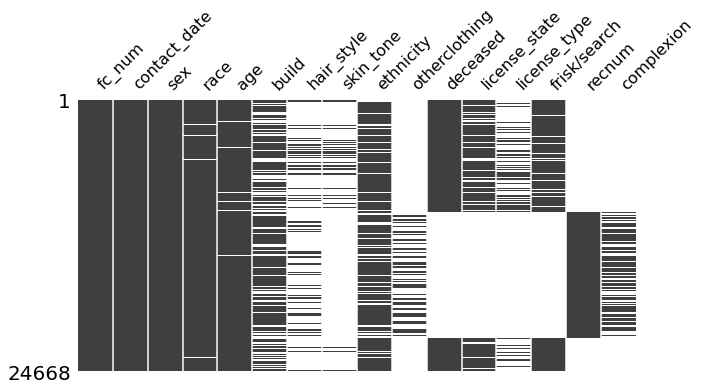

In [11]:
# sparse data for hair style, skin tone, other clothing, license_type
msno.matrix(fcn,figsize=(10, 5),sparkline=False);

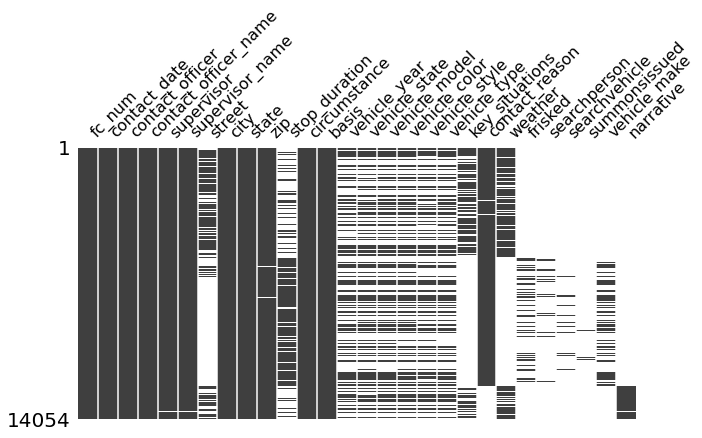

In [12]:
# sparse data for vehicle and stop duration columns
msno.matrix(fc,figsize=(10, 5),sparkline=False);

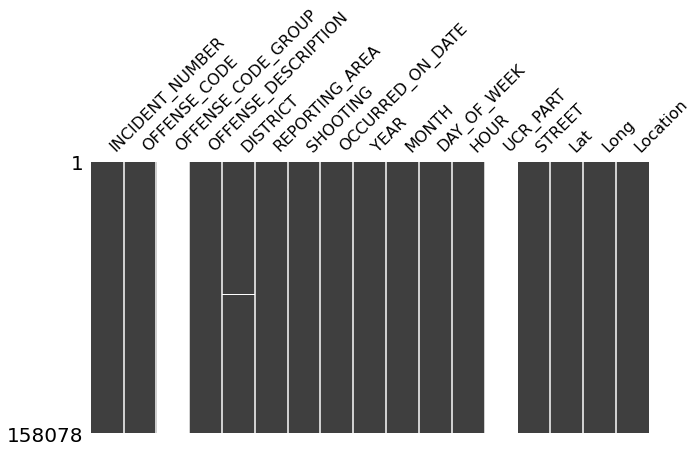

In [13]:
# missing data from offense code group and ucr part
msno.matrix(cir,figsize=(10, 5),sparkline=False);

#### **Discussion**
- Several cols that are particularly spare are `vehicle*`, `OFFENSE_CODE_GROUP`, `street`, `stop_duration` and will be dropped.
- Are columns of interest seem to have ample data available.

## Step 2: Cleaning and selecting our columns

In [14]:
def color_mapping(df, col):
    # intialize list of items from df
    random.seed(0)
    categories = df[col].to_list()
    
    # initialize color mapping
    color_map = {}
    if f'{col}_hex' not in df.columns:
        # assign random color to each category in column
        for cat in categories:
            r = lambda: random.randint(0,255)
            hex = '#%02X%02X%02X' % (r(),r(),r())
            if cat in color_map.keys():
                pass
            else:
                color_map[cat] = hex
        
        # print color mapping
        color_map_df = pd.DataFrame.from_dict(color_map, orient='index', columns=[f'{col}_hex'])\
                .reset_index()\
                .rename(columns=dict(index=col))
        
        return df.merge(color_map_df, on=col, how='left')
    else:
        df

In [15]:
# Selecting the columns of interest
fcn_df = fcn[['fc_num','contact_date','sex','race','age']].copy()

fc_df = fc[['fc_num','contact_date','supervisor','street','city','zip','state',
            'circumstance','basis','key_situations']].copy()

cir_df = cir[['INCIDENT_NUMBER','OFFENSE_CODE','OFFENSE_DESCRIPTION','DISTRICT',
              'REPORTING_AREA','OCCURRED_ON_DATE','YEAR', 'MONTH','DAY_OF_WEEK', 
              'HOUR', 'STREET','Lat','Long','Location']].copy()

# changing the columns to lowercase to consistency
cir_df.columns = cir_df.columns.str.lower()

In [16]:
# create date and month values
fc_df['date'] = pd.to_datetime(fc_df['contact_date']).dt.date
fc_df['month'] = pd.to_datetime(fc_df['contact_date']).dt.month

# create date values (month is already the data)
cir_df['date'] = pd.to_datetime(cir_df['occurred_on_date']).dt.date

# fill missing age values
#fcn_df['age'].fillna(np.median(fcn_df['age']), inplace=True)
fcn_df['age'].replace(np.nan,fcn_df['age'].median(),inplace=True)

### Mapping Dicts

The mappings below were used to help us bucket similar crimes during the analysis phase. This was due in part to the `OFFENSE_CODE_GROUP` missing from the raw data.

**TODO:** Add race and age mappings that will be used in supplemental analysis

In [17]:
# offense groupings
offense  = ["ANIMAL","ANIMAL","ANIMAL","ANIMAL","ANIMAL","ASSAULT","ASSAULT","ASSAULT","ASSAULT","ASSAULT",
            "ASSAULT","CHINS","DISORDERLY CONDUCT","DISORDERLY CONDUCT","DISORDERLY CONDUCT","DISORDERLY CONDUCT",
            "DISORDERLY CONDUCT","DISORDERLY CONDUCT","DISORDERLY CONDUCT","DISORDERLY CONDUCT","DISORDERLY CONDUCT",
            "DISORDERLY CONDUCT","DISORDERLY CONDUCT","DISORDERLY CONDUCT","DISORDERLY CONDUCT","DISORDERLY CONDUCT",
            "DISORDERLY CONDUCT","DISORDERLY CONDUCT","DISORDERLY CONDUCT","DISORDERLY CONDUCT","DISORDERLY CONDUCT",
            "DISORDERLY CONDUCT","DISORDERLY CONDUCT","DISORDERLY CONDUCT","DRUGS","DRUGS","DRUGS","DRUGS","DRUGS",
            "DRUGS","DRUGS","DRUGS","DRUGS","DRUGS","DRUGS","DRUGS","DRUGS","DRUGS","DRUGS","DRUGS","DRUGS","DRUGS",
            "DRUGS","DRUGS","DRUGS","DRUGS","DRUGS","DRUGS","DRUGS","DRUGS","DRUGS","DRUGS","FIRE REPORTS","FIRE REPORTS",
            "FIRE REPORTS","FIRE REPORTS","FIRE REPORTS","FIRE REPORTS","FIREARMS","FIREARMS","FIREARMS","FIREARMS",
            "FIREARMS","FIREARMS","FIREARMS","FIREARMS","FIREARMS","FIREARMS","FIREARMS","FRAUD","FRAUD","FRAUD","FRAUD",
            "FRAUD","FRAUD","FRAUD","FRAUD","FRAUD","FRAUD","HARASSMENT","HARASSMENT","HARASSMENT","HARASSMENT",
            "HAZARDOUS CONDITIONS","HAZARDOUS CONDITIONS","HEAVY MACHINERY","HEAVY MACHINERY","HEAVY MACHINERY",
            "HEAVY MACHINERY","HEAVY MACHINERY","HEAVY MACHINERY","HOMICIDE","HOMICIDE","HOMICIDE","INVESTIGATION",
            "INVESTIGATION","INVESTIGATION","INVESTIGATION","INVESTIGATION","KIDNAPPING","KIDNAPPING","KIDNAPPING","LANDLORD",
            "MISCELLANEOUS","MISCELLANEOUS","MISCELLANEOUS","MISCELLANEOUS","MISCELLANEOUS","MISCELLANEOUS","MISCELLANEOUS",
            "MISCELLANEOUS","MISCELLANEOUS","MISSING PERSON","MISSING PERSON","MISSING PERSON","MISSING PROPERTY","MISSING PROPERTY",
            "MISSING PROPERTY","MISSING PROPERTY","MISSING PROPERTY","MISSING PROPERTY","MISSING PROPERTY","MOTORIZED VEHICLE",
            "MOTORIZED VEHICLE","MOTORIZED VEHICLE","MOTORIZED VEHICLE","MOTORIZED VEHICLE","MOTORIZED VEHICLE","MOTORIZED VEHICLE",
            "MOTORIZED VEHICLE","MOTORIZED VEHICLE","MOTORIZED VEHICLE","MOTORIZED VEHICLE","MOTORIZED VEHICLE","MOTORIZED VEHICLE",
            "PROPERTY THEFT","PROPERTY THEFT","PROPERTY THEFT","PROPERTY THEFT","PROPERTY THEFT","PROPERTY THEFT","PROPERTY THEFT",
            "PROPERTY THEFT","PROPERTY THEFT","PROPERTY THEFT","PROPERTY THEFT","PROPERTY THEFT","PROPERTY THEFT","PROPERTY THEFT",
            "PROPERTY THEFT","PROPERTY THEFT","PROPERTY THEFT","PROPERTY THEFT","PROPERTY THEFT","PROPERTY THEFT","PROPERTY THEFT",
            "PROPERTY THEFT","PROPERTY THEFT","PROPERTY THEFT","PROPERTY THEFT","PROPERTY THEFT","PROPERTY THEFT","PROPERTY THEFT",
            "PROPERTY THEFT","PROPERTY THEFT","PROPERTY THEFT","PROPERTY THEFT","PROPERTY THEFT","PROPERTY THEFT","PROSTITUTION",
            "PROSTITUTION","PROSTITUTION","ROBBERY","ROBBERY","ROBBERY","ROBBERY","ROBBERY","ROBBERY","ROBBERY","SICK ASSIST",
            "SICK ASSIST","SICK ASSIST","SUICIDE","SUICIDE","VANDALISM","VANDALISM","VANDALISM","VICE","VICE","WARRANT","WARRANT","WARRANT"]

# offense codes
code = [3403,2613,3002,3402,3410,800,400,413,423,801,802,2608,3350,2400,3303,2641,2642,2628,2407,2600,2401,3305,3300,2671,2619,2660,2405,3304,
        2632,2604,2657,2403,2610,3301,2010,2617,1815,1807,1850,1870,1846,2102,1831,2006,1847,1806,1825,1845,1800,1805,1844,1874,1848,1830,1841,
        2007,2101,1842,1849,1843,1832,1810,3123,3122,900,2612,3160,3108,1502,3016,1500,1504,1510,2618,2648,1503,3119,2662,1501,1200,1000,1100,
        1201,1109,1001,1108,1106,1107,1102,2672,2629,2670,2647,3620,3625,2950,2906,2914,2900,2907,2905,990,100,111,3000,3102,3001,3114,3115,2500,
        2511,2622,3112,99999,3100,3170,3116,3110,3106,3109,3111,3007,3503,3501,3502,3203,3200,3202,3208,3205,3207,3201,121,3004,3811,3821,3810,
        3807,3805,3830,3820,3801,3803,3802,3831,618,561,650,670,2631,700,2616,541,500,560,562,736,542,612,531,600,1304,611,641,521,727,1300,522,
        735,706,540,615,520,616,724,619,617,613,614,1603,1601,1602,381,300,351,371,311,361,301,3018,3005,3006,3029,3008,1400,1415,1402,2204,2646,
        3130,3126,3125]

# dict for remapping code to offense_type
offense_code_mapping = dict(zip(code,offense))

In [34]:
# create mapping for transgender sex
sex_mapping = {"Male to Female Transgender":"Female",
"Transgender Male to Female":"Female",
"Female to Male Transgender": "Male",
"Transgender Female to Male":"Male",
np.NaN:"Unknown"
}

In [35]:
# dict for remapping race to race categories
race_mapping = {"Black":"Black",
                "American Indian or Alaskan Native":"Other",
                "Native American / Alaskan Native":"Other",
                "Native Hawaiian or Other Pacific Islander":"Other",
                "Native Hawaiian / Other Pacific Islander":"Other",
                "Other":"Other",
                "Asian":"Other",
                np.NaN:"Unknown",
                "Unknown":"Unknown",
                "White":"White"}

In [36]:
# adding the mappings to the new data frames
cir_df['offense_group'] = cir_df['offense_code'].replace(offense_code_mapping)
fcn_df['race_grouped'] = fcn_df['race'].replace(race_mapping)
fcn_df['sex_grouped'] = fcn_df['sex'].replace(sex_mapping)


In [37]:
#clean zip code to match zip5 format of geojson data
fc_df['ZIP5'] = fc_df['zip'].astype(str).apply(lambda x: x.zfill(5))

In [38]:
#color mappings for each data set
cir_df_color = color_mapping(cir_df,'offense_group')
fcn_df_color = color_mapping(fcn_df,'race_grouped')

fcn_df_color['age_by_decade'] = pd.cut(x=fcn_df_color['age'],bins=[10,20,30,40,50,60,70,80,90,100])

## Export Data to Excel

In [39]:
# export clean data to data file
fcn_df_color.to_excel('data/fcn_19_20.xlsx')
cir_df_color.to_excel('data/cir_19_20.xlsx')
fc_df.to_excel('data/fc_19_20.xlsx')